<h1><center><b>Recommender System</b></center></h1>
<p><center>Adrián Rubén Bedón Campaña</center></p>
<p><center>Pablo Alejandro Chasipanta Silva</center></p>
<p><center>José Miguel Merlo Santacruz</center></p>
<p><center>Dennis Steven Ocaña Santamaría</center></p>
<p><center>Xavier Alejandro Ramos Vásconez</center></p>

### Introducción

Este proyecto se centra en la implementación de un sistema de recomendación de productos basado en las opiniones que diversos usuarios han dado a los productos que han obtenido. El objetivo del sistema de recomendación identificar relaciones entre productos para personalizar la experiencia del usuario y aumentar la probabilidad de compra mediante recomendaciones relevantes. Se espera que el sistema sea capaz de sugerir productos a los usuarios que podrían tener una relación basándose en las preferencias de usuarios que mantienen intereses similares al adquirir ciertos productos.

El enfoque utilizado se basa en una proyección de red bipartita, donde la red inicial conecta usuarios con productos a partir de calificaciones, y luego se transforma a una red de productos únicamente. Esta red proyectada genera conexiones entre productos en función de la cantidad de usuarios que les asignaron una calificación alta, 5 estrellas para definir de mejor manera la población, lo cual se espera que refleje relaciones de afinidad entre productos, proporcionando una estructura de recomendación eficaz.


In [1]:
import numpy as np #Importación de la librería numpy

### Experimentación
Para el desarrollo de este proyecto se empleó una base de datos de productos y sus respectivas calificaciones, disponible en __[Kaggle](https://www.kaggle.com/)__ y proporcionada por el usuario <i>Saurav Anand</i>. Esta base de datos, que representa una red bipartita de usuarios y productos, sirve como entrada para el experimento. El objetivo es proyectar esta red bipartita para construir una red de productos interconectados en función de las preferencias de los usuarios.

Esto nos lleva a entender el concepto detrás de una red bipartita. En el campo matemático de la teoría de grafos, un grafo bipartito o bigrafo <i>(bigraph)</i>, es un tipo de grafo dentro cuyos vértices pueden dividirse en dos grupos disjuntos e independientes <i>U</i> y <i>V</i>, donde cada arista conecta un vértice de <i>U</i> con uno de <i>V</i>.

Algunos ejemplos de grafos bipartitos son los siguientes:

<div align="center"">
    <img src="Bipartite_1.png" alt="bipartite graph 1" width="400"/>
    <img src="Bipartite_2.png" alt="bipartite graph 2" width="500"/>
</div>

Ahora que se han aclarado algunos de los conceptos clave para este experimento, procederemos a leer la base de datos utilizando la biblioteca <i>__[Pandas](https://pandas.pydata.org/)__</i> de Python. Esto nos permitirá crear un <b>Dataframe</b> a partir de los datos recopilados, facilitando su etiquetado para su posterior limpieza y manipulación.

In [2]:
#Importación de la librería pandas de python
import pandas as pd

path = r'C:\Adrian\Universidad\9no Semestre\3. Fri. - Inteligencia Artificial II\ratings_Electronics.csv' #Definición de la ruta al archivo de la base de datos

df_ratings = pd.read_csv(path) #Lectura de la base de datos
df_ratings.columns = ['user_id', 'product_id', 'rating', 'timestamp'] #Etiquetado de los datos

El siguiente paso consiste en recopilar únicamente aquellos productos con una calificación de 5 estrellas, creando un subconjunto de datos a partir del <b>Dataframe</b> original.

In [3]:
df_rt5stars = df_ratings[df_ratings['rating'] == 5] #Filtrado de productos con calificación (rating) de 5 estrellas

A continuación, realizaremos la proyección de la red bipartita usando la biblioteca __[NetworkX](https://networkx.org/documentation/stable/index.html)__, a través de la cual definiremos un grafo en el cada uno de los nodos representará a un usuario y a un producto del subconjunto de datos. Luego añadiremos las aristas para establecer las conexiones dentro de la red, empleando los comandos `add_nodes_from` y `add_edges_from`

In [4]:
import networkx as nx
from networkx.algorithms import bipartite

b_network = nx.Graph() #Definición del grafo

b_network.add_nodes_from(df_rt5stars['user_id'], bipartite=0) #Adición de nodos de usuarios dentro del grafo
b_network.add_nodes_from(df_rt5stars['product_id'], bipartite=1) #Adición de nodos de productos dentro del grafo

edges = list(zip(df_rt5stars['user_id'], df_rt5stars['product_id'])) #Generación de aristas
b_network.add_edges_from(edges) #Adición de aristas dentro del grafo

Después de añadir todos los nodos y las aristas a la red, se procede a construirla con el comando `weighted_projected_graph`, proporcionando nuvamente el conjunto de productos (`product_id`) con el que se está trabajando. Para confirmar que la ejecución se completó correctamente, se imprimirá la cantidad de nodos de productos generados en la proyección y, de igual forma, el número de aristas.

**Nota:** El listado de productos se lo trabajó dentro de un `set` con el fin de evitar problemas con datos duplicados que pudieran existir.

In [5]:
products = set(df_rt5stars['product_id']) #Listado de productos
projection = bipartite.weighted_projected_graph(b_network, products) #Generación de la proyección

print("Number of product nodes:", len(projection.nodes))
print("Number of edges:", len(projection.edges))

Number of product nodes: 358457
Number of edges: 7185545


Con la proyección ya construida, el siguiente paso es generar la <i>matriz de ayacencia</i>. Debido a la cantidad de nodos obtenidos, se tomarán solo los `k`* primeros productos, seleccionados en función del número de nodos conectados.

<sub><i>*siendo k el número de productos que se desea evaluar {k < 100}</i></sub>

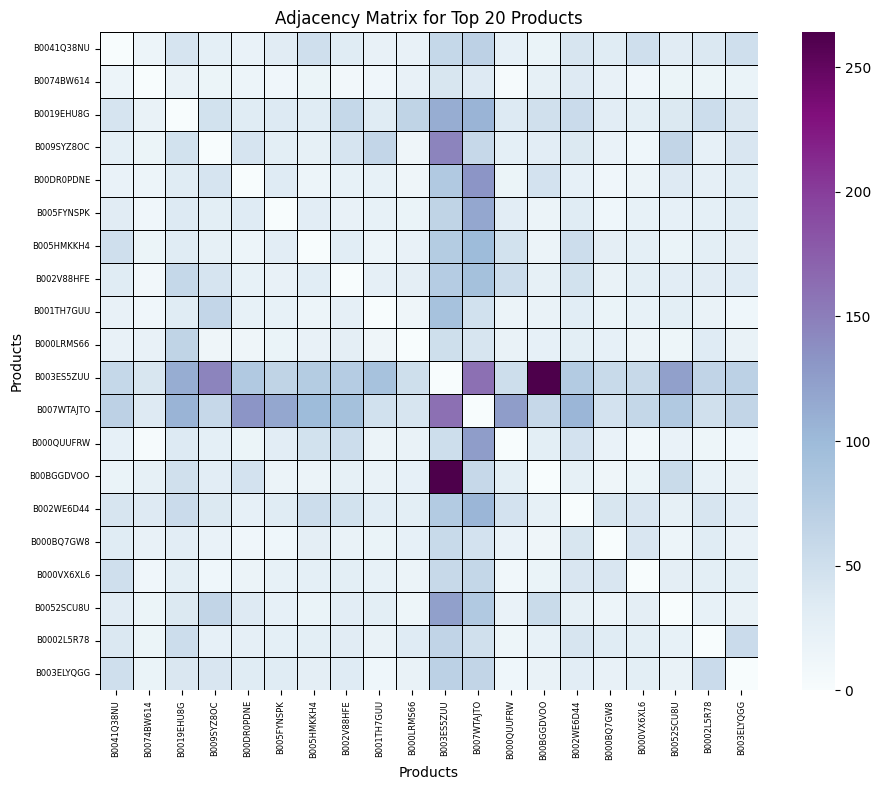

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

k = 20 #Definición del número de productos que se evaluarán para la matriz de adyacencia

# Obtención de los k productos por grado de conexión
top_k_nodes = sorted(projection.degree, key=lambda x: x[1], reverse=True)[:k]
top_k_products = [node for node, degree in top_k_nodes]

# Creación de un subgrafo únicamente con los k nodos seleccionados
projection_subgraph = projection.subgraph(top_k_products)
adj_matrix = nx.adjacency_matrix(projection_subgraph).todense()
nodes = list(projection_subgraph.nodes)

# Creación de la figura
plt.figure(figsize=(10, 8))
sns.heatmap(adj_matrix, cmap='BuPu', square=True, cbar=True, annot=False, 
            xticklabels=nodes, yticklabels=nodes, linewidths=.5, linecolor='black')

# Formato
plt.title(f"Adjacency Matrix for Top {k} Products")
plt.xlabel("Products")
plt.ylabel("Products")
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

Después de obtener la matriz de adyacencia correspondiente al top `k` de productos, procederemos a analizar de manera gráfica el estado actual de la red. Para ello, seleccionaremos un nuevo conjunto de productos con los cuales se trabajará. Tras varias pruebas, se observó que al seleccionar estos productos y ordenar los nodos por su grado de conectividad (ya sea de manera descendente o ascendente), surgían problemas en la representación de las conexiones: en el primer caso, el número de conexiones era extremadamente alto, mientras que en el segundo, las conexiones eran nulas. Esto se puede visualizar en la primer ejecución adjunta. Por esta razón, se decidió por mantener el orden descendente, pero filtrando solo aquellas conexiones con un peso superior a un valor `j` establecido <i>(en el caso de este experimento se encontró al peso 30 como el más adecuado)</i>, y los resultados de esta configuración se observan en la segunda ejecución adjunta.

##### Primera Ejecución

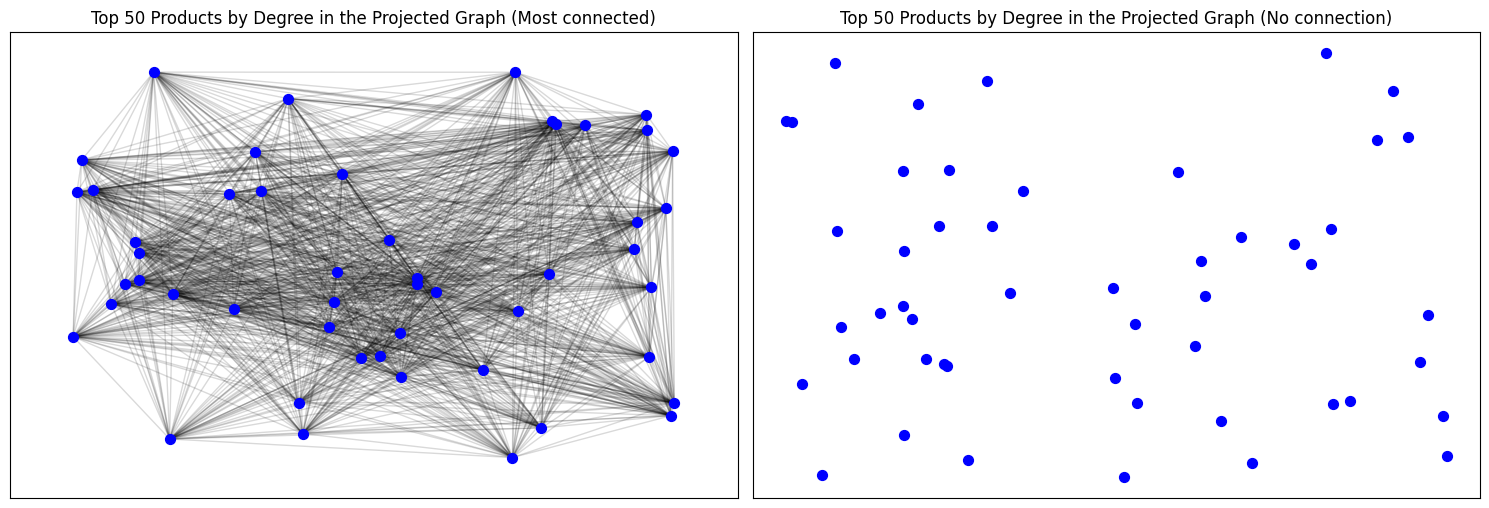

In [7]:
k = 50  # Número de productos principales a mostrar

# Obtener los top k productos por grado (nodos más conectados)
top_k_nodes_d = sorted(projection.degree, key=lambda x: x[1], reverse=True)[:k]
top_k_products_d = [node for node, degree in top_k_nodes_d]

# Obtener los top k productos por grado (nodos menos conectados)
top_k_nodes_a = sorted(projection.degree, key=lambda x: x[1], reverse=False)[:k]
top_k_products_a = [node for node, degree in top_k_nodes_a]

# Crear un subgrafo con solo los top k productos
projection_subgraph_d = projection.subgraph(top_k_products_d)
projection_subgraph_a = projection.subgraph(top_k_products_a)

node_options = {"node_color": "blue", "node_size": 50}
edge_options = {"edge_color": "black", "width": 1, "alpha":.15}

# Generación de figura para los grafos
fig = plt.figure(figsize=(15, 10))

# Grafo de nodos con el más alto grado de conexión
ax1 = fig.add_subplot(2, 2, 1)
pos_d = nx.random_layout(projection_subgraph_d)  # Distribución aleatoria
nx.draw_networkx_nodes(projection_subgraph_d, pos_d, **node_options)
nx.draw_networkx_edges(projection_subgraph_d, pos_d, **edge_options)
ax1.set_title(f"Top {k} Products by Degree in the Projected Graph (Most connected)")

ax2 = fig.add_subplot(2, 2, 2)
pos_a = nx.random_layout(projection_subgraph_a)  # Distribución aleatoria
nx.draw_networkx_nodes(projection_subgraph_a, pos_a, **node_options)
nx.draw_networkx_edges(projection_subgraph_a, pos_a, **edge_options)
ax2.set_title(f"Top {k} Products by Degree in the Projected Graph (No connection)")

plt.tight_layout()
plt.show()

##### Segunda Ejecución

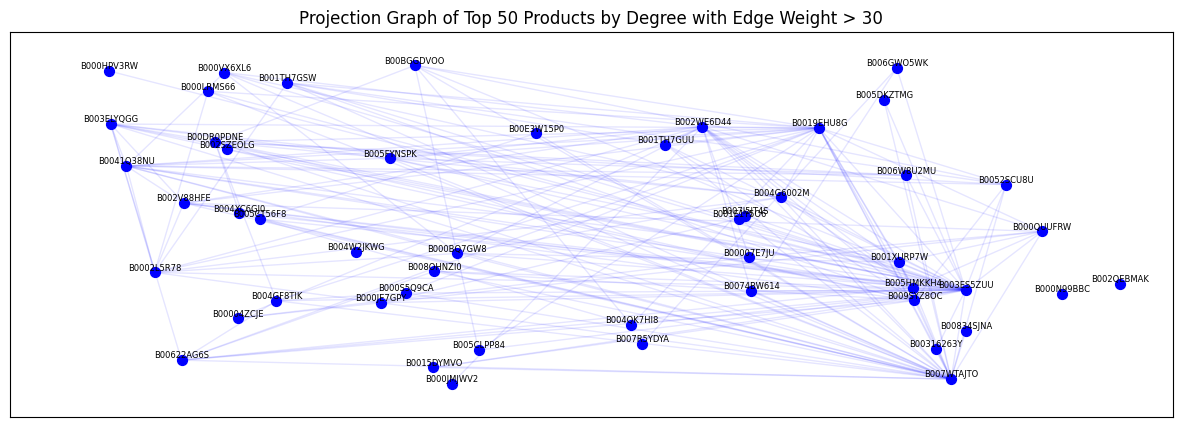

In [8]:
k = 50  # Número top de productos que se mostrarán
j = 30   # Peso mínimo (Weight) en la conexión bajo el cual se incluye una conexión en el gráfico

# Obtener el top de productos por grado de conexión
top_k_nodes = sorted(projection.degree, key=lambda x: x[1], reverse=True)[:k]
top_k_products = {node for node, degree in top_k_nodes}

# Crear una proyección reducida con los nuevos nodos
projection_topK = nx.Graph()
projection_topK.add_nodes_from(top_k_products) # Adición de nodos

# Adición de aristas solo si el nodo está dentro del top y su peso es mayor a j
projection_topK.add_edges_from(
    (u, v, d) for u, v, d in projection.edges(data=True)
    if u in top_k_products and v in top_k_products and d.get("weight", 0) > j
)

# Definición del estilo de los nodos y aristas
node_options = {"node_color": "blue", "node_size": 50}
edge_options = {"edge_color": "blue", "width": 1, "alpha": 0.10}
node_label_options = { "font_size": 6, "verticalalignment":"bottom", "horizontalalignment":"center" }

# Gráfico de la nueva proyección
plt.figure(figsize=(15, 5))
pos = nx.random_layout(projection_topK)
nx.draw_networkx_nodes(projection_topK, pos, **node_options)
nx.draw_networkx_edges(projection_topK, pos, **edge_options)
nx.draw_networkx_labels(projection_topK,pos, **node_label_options)

plt.title(f"Projection Graph of Top {k} Products by Degree with Edge Weight > {j}")
plt.show()

##### Sistema de Recomendación de Productos
A partir de las pruebas realizadas, se determinó la mejor manera de construir el sistema de recomendación de productos. Para ello, se definieron varias funciones que facilitan la implementación del sistema:
- La primera función está diseñada para recuperar las diez recomendaciones con mejor puntuación para el producto seleccionado, evitando así la sobrecarga de opciones y enfocando las sugerencias en los productos más relevantes. 

In [9]:
def get_ten_recommendations(product_id, projection):
    neighbors = [(neighbor, data['weight']) for neighbor, data in projection[product_id].items()]
    top_neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)[:10]
    return top_neighbors

- La siguiente función permite recuperar el top personalizado de recomendaciones, especificado por el usuario <i>(entre 1 y 100)</i>. Una vez seleccionado el producto y el número de recomandaciones deseadas, el sistema responde con esa cantiad de recomendaciones.

In [10]:
def get_recommendations(product_id, projection, n=5):
    neighbors = [(neighbor, data['weight']) for neighbor, data in projection[product_id].items()]
    top_neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)[:n]
    return top_neighbors

- Finalmente, se incluyó una función para construir el grafo de recomendaciones, lo que facilita la visualización del sitema. Esta función se ejecuta tras cada consulta realizada por el usuario para mostrar el grafo con las conexiones de recomendaciones.

In [11]:
def plot_network(product_id,top_neighbors,all_neighbors):
    star_network = nx.Graph()
    star_network.add_node(product_id, color='orange', size=500)

    for neighbor, weight in top_neighbors:
        star_network.add_node(neighbor, color='blue', size=300)
        star_network.add_edge(product_id, neighbor, weight=weight, color='red')

    for neighbor, weight in all_neighbors:
        if neighbor not in dict(top_neighbors):
            star_network.add_node(neighbor, color='blue', size=300)
            star_network.add_edge(product_id, neighbor, weight=weight, color='gray')

    colors = [nx.get_node_attributes(star_network, 'color').get(node, 'blue') for node in star_network.nodes]
    sizes = [nx.get_node_attributes(star_network, 'size').get(node, 300) for node in star_network.nodes]
    edge_labels = nx.get_edge_attributes(star_network, 'weight')
    edge_colors = [nx.get_edge_attributes(star_network, 'color').get(edge, 'gray') for edge in star_network.edges]

    node_options_recommendations = {"node_color": colors, "node_size": sizes}
    edge_options_recommendations = {"edge_color":edge_colors}

    plt.figure(figsize=(12, 6))
    pos = nx.spring_layout(star_network, seed=32)
    nx.draw_networkx_nodes(star_network, pos, **node_options_recommendations)
    nx.draw_networkx_edges(star_network, pos, **edge_options_recommendations)
    nx.draw_networkx_labels(star_network, pos)
    nx.draw_networkx_edge_labels(star_network, pos, edge_labels=edge_labels)

    plt.title(f"Top {len(top_neighbors)} Recommendations for Product {product_id}")
    plt.show()

<div class="alert alert-block alert-warning">
    <b>Información:</b> El siguiente apartado debe ser ejecutado de manera previa a la consulta de cualquier producto dentro del listado de productos.
</div>

##### Funcionamiento
Para el manejo del sistema desde una interfaz, se desarrollaron dos widgets `Dropdown`. El primero contiene un listado de 1000 productos seleccionados aleatoriamente en cada ejecución, evitando la carga del listado completo de productos y mejorando el rendimiento, ya que un listado completo afectaba a la capacidad de cómputo y el funcionamiento del progrma.
El segundo widget permite seleccionar un valor entre 1 y 100, correpondiente al número de recomendaciones que se desean obtener para el producto elegido, lo que ajusta la visualización la gráfica en función del producto y las recomendaciones solicitadas.
Finalmente se implementó una función central que invoca las demás funciones para construir y actualizar la gráfica de recomendaciones.

<div class="alert alert-block alert-danger">
    <b>Nota:</b> En caso de que el producto no contenga la cantidad de recomendaciones seleccionadas se mostrará el valor máximo de conexiones que este mantenga
</div>

In [12]:
import ipywidgets as widgets
from IPython.display import clear_output

sampled_products = np.random.choice(list(products), size=1000, replace=False)

dropdown_product = widgets.Dropdown(options=sampled_products, description="Product:", disabled=False)
dropdown_recommendation = widgets.Dropdown(options=np.arange(0, 101, 1), description="No. recommendations:", disabled=False)

output = widgets.Output()

def selected_product(change):
    with output:

        clear_output(wait=True)
        product_id = dropdown_product.value
        n = dropdown_recommendation.value

        top_10_neighbors = get_ten_recommendations(product_id, projection)
        top_neighbors = get_recommendations(product_id, projection, n=n)
        print("Recommended products for", product_id, ":", top_10_neighbors)
        print("Top recommended products for", product_id, ":", top_neighbors)

        plot_network(product_id, top_neighbors, top_10_neighbors)

dropdown_product.observe(selected_product, names='value')
dropdown_recommendation.observe(selected_product, names='value')

display(dropdown_product, dropdown_recommendation, output)

selected_product(None)

Dropdown(description='Product:', options=('B004FL5OUQ', 'B002QNJ29Y', 'B001873TSO', 'B0081LRO5Y', 'B00IAYHM9K'…

Dropdown(description='No. recommendations:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…

Output()

### Conclusiones y Recomendaciones

https://en.wikipedia.org/wiki/Bipartite_graph

https://www.kaggle.com/code/saurav9786/recommender-system-using-amazon-reviews/input

https://github.com/marsgr6/r-scripts/blob/master/slides/RecSys.pdf